# Шумоподавляющий автокодировщик

---

**ФИО: Шатаров Кирилл Александрович**

---

Denoising autoencoder (DAE)

Задание: создать модель для подавления шумов в медицинских изображениях.

В этой работе мы повторим идею из статьи "Medical image denoising using convolutional denoising autoencoders".

In [1]:
# код для варианта

name = "Шатаров Кирилл Александрович"

def calculate_variant(name):
    return sum(ord(char) for char in name) % 3 + 1

print(f"Ваш вариант - №{calculate_variant(name)}")

Ваш вариант - №1


## Варианты

1. OrganSMNIST
1. ChestMNIST
1. PneumoniaMNIST

## Порядок выполнения

1. Загрузить датасет по варианту;
1. Провести предварительную обработку данных;
1. Используя фреймворк PyTorch создать модель;
1. Обучить модель;
1. Попробовать подобрать гиперпараметры;
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Medical image denoising using convolutional denoising autoencoders](https://arxiv.org/pdf/1608.04667.pdf)
1. [Автоэнкодеры: типы архитектур и применение](https://neurohive.io/ru/osnovy-data-science/avtojenkoder-tipy-arhitektur-i-primenenie/)
1. [Автокодировщик](https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA)

## Статьи для примера

1. [LLNet: A Deep Autoencoder approach to Natural Low-light Image Enhancement](https://arxiv.org/pdf/1511.03995.pdf)
1. [Deep Learning on Image Denoising: An Overview](https://arxiv.org/pdf/1912.13171.pdf)
1. [Boltzmann Machines and Denoising Autoencoders for Image Denoising](https://arxiv.org/pdf/1301.3468.pdf)
1. [Denoising Vanilla Autoencoder for RGB and GS Images with Gaussian Noise](https://app.dimensions.ai/details/publication/pub.1165117438)

## Импортирование модулей

In [2]:
# Загружает один раз расширение для ноутбука. Эту команду можно перенести в самое начало.
%load_ext tensorboard

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%matplotlib inline

В этой работе можете попробовать задействовать GPU для ускорения вычислений. [How To Use GPU with PyTorch](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk)

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

Работаем на CPU


Изначально тензоры создаются на CPU, и с помощью метода `.to(device)` на тензорах и моделях вы можете переносить их с устройства на устройство. Если в результате вычислений создаются новые тензоры, то они уже создаются на устройствах, на которых производились эти вычисления.

## Загрузка данных

Ссылка на подборку датасетов - https://medmnist.com/. По этой ссылке вы найдете описание самих датасетов, а также инструкцию по установке библиотеки и созданию объекта DataClass и далее DataLoader.

[Официальный пример](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) как пользоваться датасетом и как загрузить его данные от самих разработчиков.

In [6]:
!pip install medmnist

  Obtaining dependency information for medmnist from https://files.pythonhosted.org/packages/8e/4b/83a368105698e77a7a972190973a5437a9a51789828562e1913687be9515/medmnist-3.0.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/88.4 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/88.4 kB ? eta -:--:--
     ------------- ------------------------ 30.7/88.4 kB 640.0 kB/s eta 0:00:01
     -------------------------- ----------- 61.4/88.4 kB 544.7 kB/s eta 0:00:01
     -------------------------------------- 88.4/88.4 kB 625.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for termcolor from https://files.pythonhosted.org/packages/d9/5f/8c716e47b3a50cbd7c146f45881e11d9414def768b7cd9c5e6650ec2a80a/termcolor-2.4.0-py3-none-any.whl.metadata
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117047 sha256=5e35355073c491235bb9661

In [7]:
import medmnist
from medmnist import OrganSMNIST
from medmnist import INFO, Evaluator

In [8]:
data_flag = 'organsmnist'
download = True

# NUM_EPOCHS = 3
# BATCH_SIZE = 128
# lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [9]:
print(n_channels)
print(n_classes)

1
11


In [10]:
#
# Ваш код для DataSet и DataLoader
#

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = OrganSMNIST(split="train", transform=data_transform, download=True)
test_dataset = OrganSMNIST(split="test", transform=data_transform, download=True)
# pil_dataset = OrganSMNIST(split='train', download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=train_dataset, batch_size=2*128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*128, shuffle=False)

100%|██████████| 16528359/16528359 [00:08<00:00, 1919485.51it/s]


Using downloaded and verified file: C:\Users\Lenovo\.medmnist\organsmnist.npz


In [11]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset OrganSMNIST of size 28 (organsmnist)
    Number of datapoints: 13932
    Root location: C:\Users\Lenovo\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 13932, 'val': 2452, 'test': 8827}
    Description: The OrganSMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Sagittal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in sagittal views (planes). The images are resized into 1×28×28 to pe

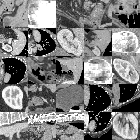

In [12]:
train_dataset.montage(length=5)

In [13]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([1, 28, 28]) (1,)


**Какие преобразования вы применили при создании DataSet и почему?**

Ваш ответ: Были применены:   
1. преобразование изображений в тензор `transforms.ToTensor()`, необходимо для работы с PyTorch;   
2. нормализация: `transforms.Normalize(mean=[.5], std=[.5]` по среднему и стандартному отклонению равным 0.5


## Создание модели

Автокодировщик (автоэнкодер) состоит из двух частей и вывод первой части является входом второй части. Строение модели вы можете посмотреть в статье в описании и воспроизвести ее. Создание слоев свертки вам знакомо с предыдущей работы, а для декодера вам потребуется двумерная транспонированная свертка (ConvTranspose2d).

In [15]:
# кодировщик
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

    self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

    self.conv5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 11))

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x  # здесь на выходе может быть произвольный тензор


#  декодер
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Sequential(
            nn.Linear(11, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 4 * 4),
            nn.ReLU()
        )

    self.deconv1  = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

    self.deconv2  = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

    self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

    self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

    self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Для нормализации выхода в диапазон [0, 1]
        )

  def forward(self, x):
    # Помните, что здесь на входе должен приниматься тензор размерностью как у кодировщика на выходе
    x = self.fc(x)
    x = x.view(x.size(0), 64, 4, 4)  # Reshape в тензор 64x4x4
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)
    x = self.deconv4(x)
    x = self.deconv5(x)
    return x  # На выходе должен быть тензор размерностью как исходное изображение (1, 28, 28).

**В чем разница между сверткой и транспонированной сверткой?**

Ваш ответ: Свертка используется для извлечения признаков из входных данных, таких как изображения.Ее цель – сжать или уменьшить размерность данных, выделив важные признаки.   
Транспонированная свертка (обратная свертка), применяется для увеличения размерности данных. Она используется в генеративных моделях и автоэнкодерах для восстановления данных до исходного размера. Ее цель – увеличить размерность данных, восстановив исходную структуру.

Далее кодировщик и декодировщик мы объединяем в автокодировщик.

In [16]:
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Обучение

В качестве оптимизатора можете использовать SGD или Adam или в целом попробовать другие оптимизаторы, что предлагает pytorch.

В качестве функции потерь воспользуйтесь MSE (MSELoss) или другой функцией, которая подходит для сравнения изображений.

In [17]:
epochs = 100
learning_rate = 0.001 # (было 0.002, 0.02, 0.0085, 0.0055)

# Определение экземпляров кодировщика и декодировщика
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Создание модели автоэнкодера
model = Autoencoder(encoder, decoder).to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

In [18]:
writer = SummaryWriter()  # создание экземпляра класса, который отвечает за ведение логов

best_loss = float('inf')
train_losses = []
val_losses = []

log_dict = {
    'training_loss_per_batch': [],
    'validation_loss_per_batch': [],
}

for epoch in range(epochs):

  train_losses = []

  print(f'Эпоха {epoch+1}/{epochs}')
  print('обучение...')
  model.train()
  running_loss = 0
  for batch_idx, (images, _) in enumerate(train_loader):  # Изменение здесь
    images = images.to(device)

    # Шаги для обучения:
    # 1. загрузить изображения
    # images = images[0]

    # 2. добавить гауссовский шум шум (torch.normal() и clip() / clamp())
    noisy_images = images + torch.normal(0, 0.1, size=images.shape).to(device)
    noisy_images = torch.clamp(noisy_images, 0., 1.)

    # 3. реконструировать изображение (прямой проход через энкодер и декодер)
    outputs = model(noisy_images)

    # 4. рассчитать `loss`
    loss = loss_fn(outputs, images)

    # 5. выполнить `loss.backward ()` для вычисления градиентов функции потери относительно параметров модели
    optimizer.zero_grad()
    loss.backward()

    # 6. выполнить шаг оптимизации `optimizer.step ()`
    optimizer.step()
    running_loss += loss.item()

    # 7. занулить градиенты
    optimizer.zero_grad()

    log_dict['training_loss_per_batch'].append(loss.item())
    writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)  # Логирование

  train_losses.append(running_loss / len(train_loader))
  print(f'Эпоха [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}')

  # Валидация
  print('валидация...')
  model.eval()
  val_running_loss = 0
  for val_batch_idx, (val_images, _) in enumerate(val_loader):  # Изменение здесь
    val_images = val_images.to(device)
    with torch.no_grad():
      noisy_val_images = val_images + torch.normal(0, 0.1, size=val_images.shape).to(device)
      noisy_val_images = torch.clamp(noisy_val_images, 0., 1.)

      val_outputs = model(noisy_val_images)
      val_loss = loss_fn(val_outputs, val_images)

      val_running_loss += val_loss.item()
      log_dict['validation_loss_per_batch'].append(val_loss.item())
      writer.add_scalar('Loss/validation', val_loss.item(), epoch * len(val_loader) + val_batch_idx)  # Логирование

  val_losses.append(val_running_loss / len(val_loader))
  print(f'Эпоха [{epoch+1}/{epochs}], Validation Loss: {val_running_loss / len(val_loader)}')

  if val_running_loss < best_loss:
      best_loss = val_running_loss
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              }, "best_model_params.pth")

print("Обучение завершено.")

writer.close()

Эпоха 1/100
обучение...
Эпоха [1/100], Loss: 0.36383254210883326
валидация...
Эпоха [1/100], Validation Loss: 0.2816449750553478
Эпоха 2/100
обучение...
Эпоха [2/100], Loss: 0.27067662994249153
валидация...
Эпоха [2/100], Validation Loss: 0.25855303298343313
Эпоха 3/100
обучение...
Эпоха [3/100], Loss: 0.2550783531928281
валидация...
Эпоха [3/100], Validation Loss: 0.25051095729524436
Эпоха 4/100
обучение...
Эпоха [4/100], Loss: 0.24677585776245922
валидация...
Эпоха [4/100], Validation Loss: 0.2433594755151055
Эпоха 5/100
обучение...
Эпоха [5/100], Loss: 0.24222958511715637
валидация...
Эпоха [5/100], Validation Loss: 0.24043880159204656
Эпоха 6/100
обучение...
Эпоха [6/100], Loss: 0.23970577776978869
валидация...
Эпоха [6/100], Validation Loss: 0.23879469578916376
Эпоха 7/100
обучение...
Эпоха [7/100], Loss: 0.23774448693345446
валидация...
Эпоха [7/100], Validation Loss: 0.237667392058806
Эпоха 8/100
обучение...
Эпоха [8/100], Loss: 0.23627274873059825
валидация...
Эпоха [8/100], Va

Эпоха [63/100], Loss: 0.2240008828016596
валидация...
Эпоха [63/100], Validation Loss: 0.22404917993328788
Эпоха 64/100
обучение...
Эпоха [64/100], Loss: 0.2240837014049565
валидация...
Эпоха [64/100], Validation Loss: 0.2236464329741218
Эпоха 65/100
обучение...
Эпоха [65/100], Loss: 0.22391873516074015
валидация...
Эпоха [65/100], Validation Loss: 0.22345794683152978
Эпоха 66/100
обучение...
Эпоха [66/100], Loss: 0.2239067115641515
валидация...
Эпоха [66/100], Validation Loss: 0.2234988651492379
Эпоха 67/100
обучение...
Эпоха [67/100], Loss: 0.2237991983190589
валидация...
Эпоха [67/100], Validation Loss: 0.22328079342842103
Эпоха 68/100
обучение...
Эпоха [68/100], Loss: 0.22371544777800184
валидация...
Эпоха [68/100], Validation Loss: 0.22308357385071842
Эпоха 69/100
обучение...
Эпоха [69/100], Loss: 0.223627935172221
валидация...
Эпоха [69/100], Validation Loss: 0.2229795583269813
Эпоха 70/100
обучение...
Эпоха [70/100], Loss: 0.22346360174887772
валидация...
Эпоха [70/100], Validat

**Что делает clip() или clamp() и почему его требуется использовать после добавления шума?**

Ваш ответ: Функции clip() (в NumPy) и clamp() (в PyTorch) используются для ограничения значений элементов тензора в заданном диапазоне. Их требуется использовать после добавления шума к изображениям, так как эти функции служат для поддержания значений пикселей в допустимых пределах, например, от 0 до 1 для нормализованных изображений.

## Контроль результатов и экспериментов

Вы всегда должны следить за тем как идет обучение и как меняются метрики в его процессе. В этой работе вы можете воспользоваться [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html) или создать переменную со списком и в него складывать значения с каждых n итераций и с помощью matplotlib строить графики.

Далее приведены части кода, которые позволят в Google Colab воспользоваться TensorBoard для PyTorch.

In [19]:
%tensorboard --logdir runs  # Запускает TensorBoard в выводе текущей ячейки

**По графикам потерь и метрике сделайте вывод была ли модель обучена, недообучена или переобучена.**

Ваш ответ: На основании данных, можно сделать вывод, что модель была обучена корректно. Ошибки на тренировочной и валидационной выборках снижаются и находятся на сопоставимом уровне, что говорит о хорошей обобщающей способности модели.

**Если модель недообучена или переобучена, то что могло послужить причинами этого?**

Ваш ответ:

## Результат работы модели

Выведите итоговую метрику для тестовых изображений. И отобразите несколько примеров работы модели: исходное изображение и с убранным шумом.

Пример для цветных изображений.

```python
test_images = test_images.to(device)
with torch.no_grad():
  reconstructed_imgs = network(test_images)
reconstructed_imgs = reconstructed_imgs.cpu()
test_images = test_images.cpu()
imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], dim=1).flatten(0,1)
grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
grid = grid.permute(1, 2, 0)
plt.figure(dpi=170)
plt.title('Original/Reconstructed')
plt.imshow(grid)
log_dict['visualizations'].append(grid)
plt.axis('off')
plt.show()
```

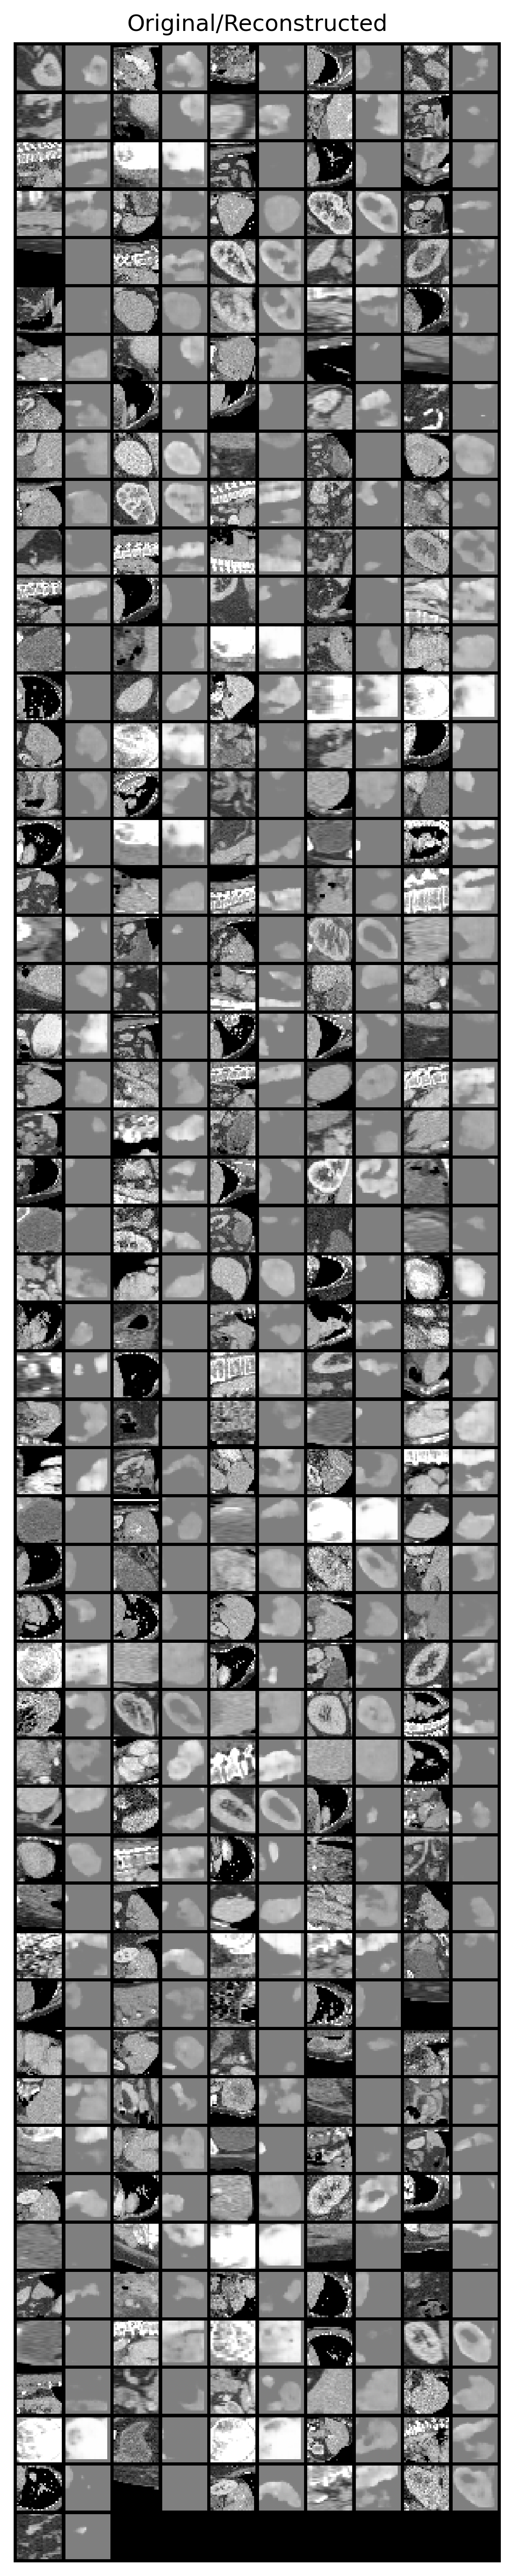

Средняя потеря на тестовых данных: 0.0067


In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Определим функцию для отображения результатов
def show_reconstructed_images(original_images, reconstructed_images, n_images=10):
    original_images = original_images.cpu().detach()
    reconstructed_images = reconstructed_images.cpu().detach()

    # Подготовка изображений для отображения
    imgs = torch.stack([original_images.view(-1, 1, 28, 28), reconstructed_images.view(-1, 1, 28, 28)], dim=1).flatten(0,1)
    grid = make_grid(imgs, nrow=n_images, normalize=True, padding=2)
    grid = grid.permute(1, 2, 0)

    plt.figure(figsize=(24, 24), dpi=300)  # Увеличиваем размер фигуры и DPI
    plt.title('Original/Reconstructed')
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

# Тестирование модели и вывод метрики
model.eval()
test_loss = 0
with torch.no_grad():
    for test_images, _ in test_loader:  # предполагается, что test_loader загружен
        test_images = test_images.to(device)

        # Добавление шума и реконструкция изображений
        noisy_test_images = test_images + torch.normal(0, 0.1, size=test_images.shape).to(device)
        noisy_test_images = torch.clamp(noisy_test_images, 0., 1.)

        reconstructed_imgs = model(noisy_test_images)

        # Вычисление потерь для тестовых изображений
        test_loss += loss_fn(reconstructed_imgs, test_images).item()

        # Отображение примеров реконструированных изображений
        # if test_loss == 0:  # показываем только первый батч изображений
        show_reconstructed_images(test_images, reconstructed_imgs)
        break

test_loss /= len(test_loader)
print(f'Средняя потеря на тестовых данных: {test_loss:.4f}')


## Контрольные вопросы

**В чем особенность архитектуры автокодировщиков?**

Ваш ответ: Автокодировщики имеют уникальную архитектуру, состоящую из трех основных частей: энкодера, промежуточного слоя с наименьшим количеством нейронов и декодера. Энкодер преобразует входные данные в сжатое представление, проходя через несколько слоев, обычно уменьшая размерность данных. Промежуточный слой является наиболее сжатым представлением данных, где хранится основная информация. Декодер восстанавливает исходные данные из этого сжатого представления, увеличивая размерность данных через зеркальные слои относительно энкодера. Эта архитектура позволяет автокодировщикам эффективно обучаться без меток, сжимать данные, удалять шум и обнаруживать аномалии.

**Какие метрики можно использовать для оценки качества изображений?**

Ваш ответ: Для оценки качества изображений можно использовать:   
**Среднеквадратичная ошибка (Mean Squared Error, MSE):** измеряет среднеквадратичную разницу между значениями пикселей исходного и реконструированного изображений.   
**Структурное сходство (Structural Similarity Index, SSIM):** измеряет структурное сходство между исходным и реконструированным изображениями. Он учитывает восприятие яркости, контраста и структуры.   
**Средняя абсолютная ошибка (Mean Absolute Error, MAE):** измеряет среднюю абсолютную разницу между значениями пикселей исходного и реконструированного изображений.


In [37]:
train_loss = [
    0.36383254210883326, 0.27067662994249153, 0.2550783531928281, 0.24677585776245922,
    0.24222958511715637, 0.23970577776978869, 0.23774448693345446, 0.23627274873059825,
    0.23492286620883768, 0.23424836296007173, 0.23342184886473036, 0.2326522678683657,
    0.23223336560463687, 0.23176950831478887, 0.23145978986670118, 0.23102828737245787,
    0.230653350232938, 0.23041438851334634, 0.23019076487339965, 0.23000521725470865,
    0.22960362932003966, 0.2293326637340248, 0.2291384071385095, 0.22888368163086953,
    0.22870288884967838, 0.22829813858784667, 0.22824322603164462, 0.2280915851166489,
    0.2280184961513642, 0.22760727892228222, 0.22751903082799474, 0.22737949348370964,
    0.22726398856814847, 0.22700965226790226, 0.22682252403246153, 0.22682287892617217,
    0.22671017242134164, 0.22663245657715228, 0.2266456707628495, 0.2263065613464478,
    0.22630841305496496, 0.22604796345080805, 0.22608956680932177, 0.22596416410503037,
    0.22565738063886626, 0.22536357458031506, 0.22548298072924308, 0.2255066437732189,
    0.22507989379244114, 0.22496038224172155, 0.22501255640196144, 0.22501860791390096,
    0.2249807767364957, 0.2247024507970985, 0.22477902321640506, 0.22446113865856732,
    0.22465541781088627, 0.22443810365068803, 0.2243844027366113, 0.224668486539377,
    0.22417118174767275, 0.22412240368510605, 0.2240008828016596, 0.2240837014049565,
    0.22391873516074015, 0.2239067115641515, 0.2237991983190589, 0.22371544777800184,
    0.223627935172221, 0.22346360174887772, 0.223439879236965, 0.22346572427574649,
    0.22340468939291228, 0.22337459437890883, 0.22319790461194625, 0.22336915012346495,
    0.22322568119665898, 0.22322289878075277, 0.22328819594252, 0.22303530327770688,
    0.22290202141354937, 0.22290154785738078, 0.22307645290269765, 0.22310203546230947,
    0.22274611015385443, 0.22264779776061347, 0.22257216329421473, 0.22254531399919353,
    0.22243188718043336, 0.2223843057221229, 0.22255747170623288, 0.22244165468653407
]

In [39]:
val_loss = [0.2816449750553478,
 0.25855303298343313,
 0.25051095729524436,
 0.2433594755151055,
 0.24043880159204656,
 0.23879469578916376,
 0.237667392058806,
 0.23575185537338256,
 0.23415592150254683,
 0.23345820280638607,
 0.23281272216276688,
 0.23240388984029944,
 0.23179541338573803,
 0.23132361471652985,
 0.23087915642694992,
 0.23075763474811206,
 0.2301553257487037,
 0.22971574122255498,
 0.22979745837775142,
 0.2295698799870231,
 0.22897309308702296,
 0.22877419916066258,
 0.22916501218622382,
 0.22896132469177247,
 0.2282946074550802,
 0.22809722044251182,
 0.2276117750189521,
 0.22754797312346373,
 0.22720561135898937,
 0.22763675126162441,
 0.22712429761886596,
 0.2268969403071837,
 0.22662612714550712,
 0.22629528831351886,
 0.22626057483933187,
 0.2263196961446242,
 0.2263534518805417,
 0.22616021849892357,
 0.2258358058604327,
 0.2261472368782217,
 0.22561766505241393,
 0.22571078945289957,
 0.2257666891271418,
 0.22538040334528142,
 0.2251141372052106,
 0.22506024431098592,
 0.22530779730189932,
 0.22479510063474828,
 0.22471337562257593,
 0.22461446930061688,
 0.2248196935111826,
 0.22481724728237498,
 0.22455274110490625,
 0.2243492535569451,
 0.22427938986908305,
 0.22399499714374543,
 0.22430475868962027,
 0.224218089743094,
 0.2239931810985912,
 0.22411627661098132,
 0.22384748052467,
 0.2238800040700219,
 0.22404917993328788,
 0.2236464329741218,
 0.22345794683152978,
 0.2234988651492379,
 0.22328079342842103,
 0.22308357385071842,
 0.2229795583269813,
 0.22294271967627785,
 0.22306900918483735,
 0.22336479994383726,
 0.222936227646741,
 0.22306420911442149,
 0.22294112660668114,
 0.2235548501664942,
 0.22305506955493581,
 0.22303124286911705,
 0.2228166181932796,
 0.2226224812594327,
 0.2224492289803245,
 0.22282671576196497,
 0.22294392775405536,
 0.22283371253447098,
 0.22268762778152118,
 0.22208030711520801,
 0.2224930075081912,
 0.22226397774436257,
 0.2220327531749552,
 0.2220166333697059,
 0.22229569473049857,
 0.22189438939094544]

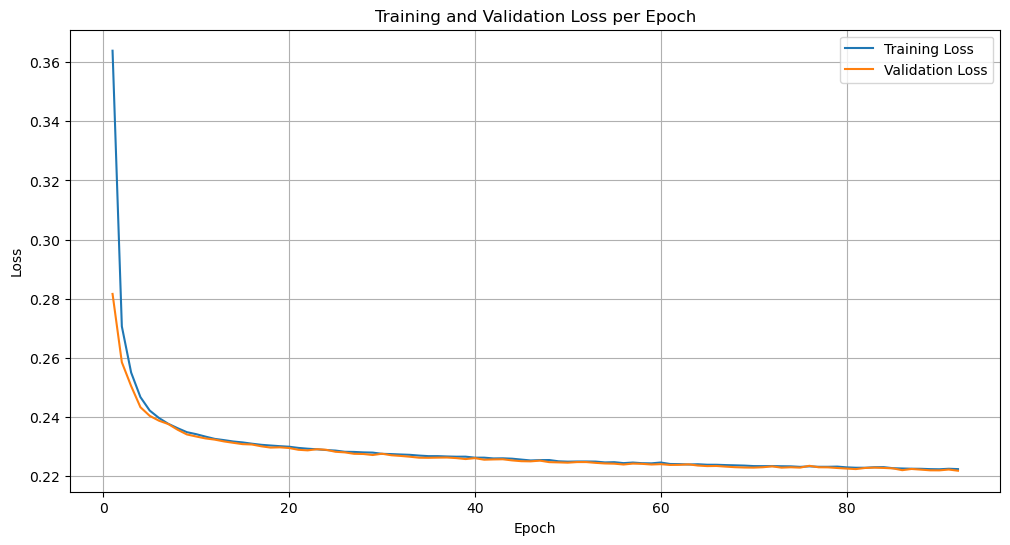

In [49]:
import matplotlib.pyplot as plt

# Данные по эпохам
epochs = list(range(1, 93))

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()